<a href="https://colab.research.google.com/github/SimNaeun/Google_Bootcamp/blob/main/Zzzs_Random_Forest_model_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 훈련 데이터 불러오기

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"snaeun","key":"c04c44621f2fcba7568fe3e146ec700d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d carlmcbrideellis/zzzs-lightweight-training-dataset-target

zzzs-lightweight-training-dataset-target.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip zzzs-lightweight-training-dataset-target.zip

Archive:  zzzs-lightweight-training-dataset-target.zip
replace Zzzs_train.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
from itertools import groupby
import gc

In [ ]:
train = pd.read_parquet("/content/Zzzs_train_multi.parquet")

#EDA
https://www.kaggle.com/code/gvyshnya/to-sleep-or-not-to-sleep-deep-eda-dive#Deep-Dive-into-Training-Events

anglez: angle of the arm relative to the vertical axis of the body

enmo: euclidean norm minus one

time periods= 20~30 days

time sparsity=2017~2019year(almost 2years)

onset 시간:오후 8시부터 11시 사이에 대부분 분포

wakeup 시간: 오전 6시부터 8시에 대부분 분포

사람 수(series) 277

총 데이터 수 14508

20~29밤에 대부분 분포(측정횟수가 가장 적은 사람은 1밤, 가장 많은 사람은 84밤, 중앙값은 14밤, 평균은 15밤)

그 중 series_id 78569a801a38인 사람의 데이터가 가장 많음(84번의 밤)

fully labelled series 37/277

partially labelled series 232/277

without any events labelled at all 8/277

수면시간(sleep_duration)은 8~10hr에 대부분 분포, 9hr이 최다

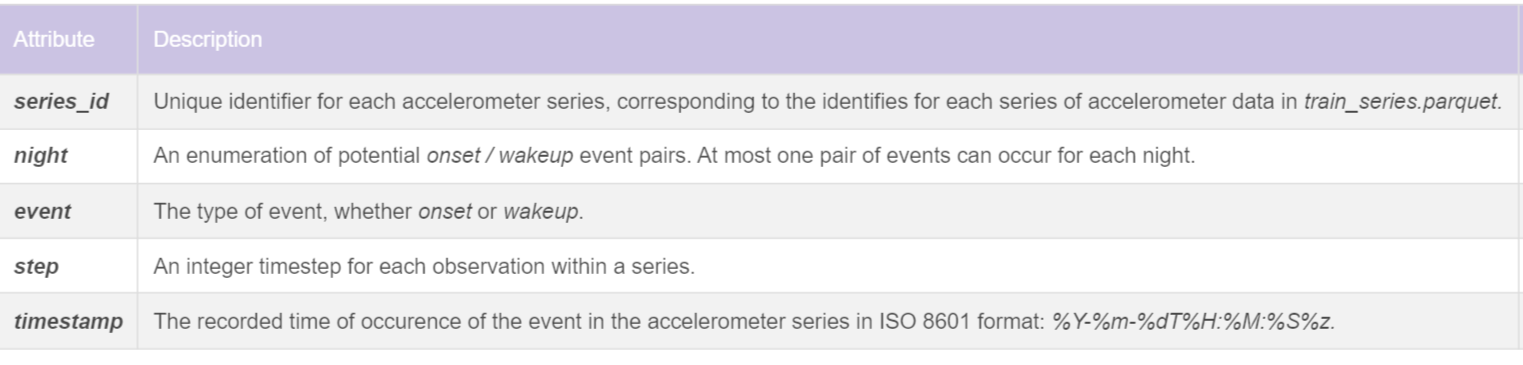






# 피쳐 엔지니어링

In [ ]:
#피쳐 엔지니어링:
def make_features(df):
    # to_datatime로 날짜 및 시간형식으로 변환하고 tz_localize(None)으로 타임존 정보 제거
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df["hour"] = df["timestamp"].dt.hour

    #anglez, enmo열에 대한 다양한 통계량 계산
    #이동 평균 frame 접근방식: 시계열의 각 데이터 포인트에 대한 통계량이 지정된 periods변수에 따라 정의된
    #이전 데이터 포인트릐 고정된 수에 기반하여 계산

    #fillna('bfill'): 뒤쪽으로 유효한 관측치를 앞으로 전파
    #fillna('ffill'): 앞쪽으로 유요한 관측치를 뒤로 전파
    #해서 결측값이 없도록

    #'float16' 메모리 사용량 줄이기

    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')

    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

In [ ]:
train   = make_features(train)

X_train = train[features]
y_train = train["awake"]

del train  # train 데이터프레임 삭제->메모리 용량 줄이기
gc.collect(); # 메모리에서 불필요한 객체 및 데이터 정리, 메모리 최적화

AttributeError: ignored

# 모델링 및 트레이닝


In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier
# 50개 결정트리, 각 결정트리의 최소 마지막 노드 수 300개
# n_jobs=-1 모델 병렬로 실행하고 가능한 모든 CPU 코어 사용
classifier = RandomForestClassifier(n_estimators=50,
                                    min_samples_leaf=300,
                                    random_state=42,n_jobs=-1)
#randomforest 분류 모델 훈련
classifier.fit(X_train, y_train)

#메모리 최적화
del X_train, y_train
gc.collect();

# 테스트 데이터로 예측


In [ ]:
#테스트 데이터 불러오기
test  = pd.read_parquet("/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet")

#테스트 데이터에 새로운 특성 생성
test  = make_features(test)

#데스트 데이터에 대한 특성 데이터
X_test = test[features]

#radomforest 분류 모델(classifier)을 사용해 각 샘플이 클래스 0(not awake)에 속할 확률
test["not_awake"] = classifier.predict_proba(X_test)[:,0]

#radomforest 분류 모델(classifier)을 사용해 각 샘플이 클래스 1(awake)에 속할 확률
test["awake"]     = classifier.predict_proba(X_test)[:,1]

In [ ]:
#smoothing을 사용해 데이터를 부드럽게 만들고 smooth열을 이진화해 이벤트를 감지하고 각 이벤트의 시작과 종료 식별


#smoothing: 이동평균을 사용해 데이터를 부드럽게 만듦
smoothing_length = 2*230

#스무딩된 값 계산
# center=True 중앙에 위치한 값으로 계산
#rolling: 이동평균 계산
#fillna(method="bfill").fillna(method="ffill") 이전 또는 다음 유효한 값으로 채워 결측값이 제거되고 부드러운 곡선

test["score"]  = test["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
test["smooth"] = test["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")

#round 반올림을 사용해 다시 이진화 -> 0 또는 1의 값을 가짐
test["smooth"] = test["smooth"].round()

# https://stackoverflow.com/questions/73777727/how-to-mark-start-end-of-a-series-of-non-null-and-non-0-values-in-a-column-of-a
# df.series_id 열과 df.smooth 열을 순회하며 0이 아니고 결측값이 아닌 경우 onset(수면시작시간)으로 표시
# 이어서 wakeup(수면끝난시간)으로 표시하거나 계속 이벤트를 찾아나감
# 이벤트 정보는 event열에 저장
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv:
                            (cv[0], cv[1]!=0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0]*llg)
        else:
            lstPOI.extend(['onset']+(llg-2)*[0]+['wakeup'] if llg > 1 else [0])
    return lstPOI

test["event"] = get_event(test)

In [ ]:
sample_submission = test.loc[test["event"] != 0][["series_id","step","event","score"]].copy().reset_index(drop=True).reset_index(names="row_id")
sample_submission.to_csv('submission.csv', index=False)